In [10]:
##### DEFINITIONS ##########

def my_Hamming_code(r):
    V = GF(2)^r;
    H = matrix([V[i] for i in range(1,2^r)]).transpose()
    return H.right_kernel()
    G = H.right_kernel()

def hamming_decode(H, received):
    n = H.ncols()
    r = H.nrows()
    H = G.right_kernel().matrix()
    # Compute syndrome
    syndrome = H * received

    # Syndrome is 0 → no error
    if syndrome == vector(GF(2), r*[0]):
        return received

    # Otherwise, find error position
    # Syndrome matches a column of H
    for j in range(n):
        if H.column(j) == syndrome:
            corrected = received.list()
            corrected[j] += 1  # Flip the error bit
            return vector(GF(2), corrected)

    # If not found (should not happen in simple BSC), return received anyway
    return received

############################

def my_binary_symmetric_channel(v,p):
    n = len(v)
    # so that v is not changed
    w = [0 for i in range(n)];
    for i in range(n):
        x = ZZ.random_element(0,100)
        if x < p*100:
            w[i] = 1
    return v + (GF(2)^n)(w)


##### REPETITION CODE ##########

def repetition_encode(bit):
    return vector(GF(2), [bit]*7)

def repetition_decode(codeword):
    return int(sum(map(int, codeword)) >= 4)
##### LRC ENCODE ##########

def lrc_encode(message):
    # message is length 4: [m1, m2, m3, m4]
    m1, m2, m3, m4 = message
    p1 = m1 + m2
    p2 = m3 + m4
    p3 = m1 + m2 + m3 + m4
    return vector(GF(2), [m1, m2, m3, m4, p1, p2, p3])

##### LRC DECODE ##########

def lrc_decode(received):
    # received is a length-7 vector
    # Try local repairs first
    m1, m2, m3, m4, p1, p2, p3 = received

    # First local group (m1, m2, p1)
    group1 = [m1, m2, p1]
    if group1.count(None) == 1:
        idx = group1.index(None)
        group1[idx] = group1[(idx+1)%3] + group1[(idx+2)%3]
    m1, m2, p1 = group1

    # Second local group (m3, m4, p2)
    group2 = [m3, m4, p2]
    if group2.count(None) == 1:
        idx = group2.index(None)
        group2[idx] = group2[(idx+1)%3] + group2[(idx+2)%3]
    m3, m4, p2 = group2

    # Global check
    if (m1 is None) or (m2 is None) or (m3 is None) or (m4 is None):
        known = [m1, m2, m3, m4]
        missing = [i for i in range(4) if known[i] is None]
        if len(missing) == 1:
            idx = missing[0]
            # Recover the missing one using p3
            known_sum = sum([bit for bit in known if bit is not None])
            known[idx] = p3 + known_sum
            m1, m2, m3, m4 = known

    return vector(GF(2), [m1, m2, m3, m4])


v = vector(GF(2), [0, 0, 0, 0, 0, 0, 0])
decoded = repetition_decode(v)
print("Decoded:", decoded)


Decoded: 0


In [34]:
s = sum(vector(GF(2), [0, 0, 0, 0, 0, 0, 0]))
print("Sum:", s, "Type:", type(s))
print("s >= 4:", s >= 4)
print("s < 4:", s < 4)
print("s == 0:", s == 0)
print("s > 4:", s > 4)
print("s <= 4:", s <= 4)
print("int(s):", int(s))


Sum: 0 Type: <class 'sage.rings.finite_rings.integer_mod.IntegerMod_int'>
s >= 4: True
s < 4: False
s == 0: True
s > 4: False
s <= 4: True
int(s): 0


In [6]:
print("\nTesting Repetition Code:")

# Random message (bit 0 or 1)
bit = randint(0, 1)

# Encode
rep_codeword = repetition_encode(bit)

# Send through BSC
rep_corrupted = my_binary_symmetric_channel(rep_codeword, 0.9)  # 10% flip prob

# Decode
decoded_bit = repetition_decode(rep_corrupted)

# Output results
print("Original Bit:", bit)
print("Encoded Codeword:", rep_codeword)
print("Corrupted Codeword:", rep_corrupted)
print("Decoded Bit:", decoded_bit)
print("Success:", decoded_bit == bit)




Testing Repetition Code:
Running NEW decoder
Original Bit: 1
Encoded Codeword: (1, 1, 1, 1, 1, 1, 1)
Corrupted Codeword: (0, 0, 0, 0, 0, 0, 0)
Decoded Bit: 0
Success: False


In [33]:
print("\nTesting Hamming Code:")

# Setup Hamming Code
C = my_Hamming_code(3);  # [7,4]
G = matrix(C.basis())

# Random 4-bit message
message = vector(GF(2), [randint(0,1) for _ in range(4)])

# Encode
ham_codeword = message * G

# Send through BSC
ham_corrupted = my_binary_symmetric_channel(ham_codeword, 0.01)

# Decode manually using syndrome decoding
decoded_codeword = hamming_decode(H, ham_corrupted)


# Try to recover original message inside try/except
try:
    decoded_message = G.solve_left(decoded_codeword)
    success = (decoded_message == message)
except ValueError:
    decoded_message = None
    success = False



    
# Output results
print("Original Message:", message)
print("Encoded Codeword:", ham_codeword)
print("Corrupted Codeword:", ham_corrupted)
print("Decoded Codeword:", decoded_codeword)
print("Decoded Message:", decoded_message)
print("Success:", decoded_message == message)



Testing Hamming Code:
Original Message: (1, 0, 0, 1)
Encoded Codeword: (1, 0, 0, 1, 1, 0, 0)
Corrupted Codeword: (0, 0, 0, 1, 1, 0, 0)
Decoded Codeword: (1, 0, 0, 1, 1, 0, 0)
Decoded Message: (1, 0, 0, 1)
Success: True


In [36]:
print("\nTesting LRC Code:")

# Random 4-bit message
lrc_message = [randint(0,1) for _ in range(4)]

# Encode
lrc_codeword = lrc_encode(lrc_message)

# Send through BSC
lrc_corrupted = my_binary_symmetric_channel(lrc_codeword, 0.1)

# Decode
lrc_decoded_message = lrc_decode(lrc_corrupted)

# Output results
print("Original Message:", lrc_message)
print("Encoded Codeword:", lrc_codeword)
print("Corrupted Codeword:", lrc_corrupted)
print("Decoded Message:", lrc_decoded_message)
print("Success:", lrc_decoded_message == vector(GF(2), lrc_message))



Testing LRC Code:
Original Message: [1, 1, 0, 0]
Encoded Codeword: (1, 1, 0, 0, 0, 0, 0)
Corrupted Codeword: (1, 1, 0, 0, 1, 0, 0)
Decoded Message: (1, 1, 0, 0)
Success: True


In [7]:
def simulate_trials_for_repetition(p_list, num_trials):
    success_rates = []
    for p in p_list:
        successes = 0
        for _ in range(num_trials):
            bit = randint(0, 1)
            encoded = repetition_encode(bit)
            corrupted = my_binary_symmetric_channel(encoded, p)
            decoded = repetition_decode(corrupted)
            if decoded == bit:
                successes += 1
        success_rates.append(successes / num_trials)
    return success_rates


In [37]:
p_list = [0.01 * i for i in range(1, 61)]  # [0.01, 0.02, ..., 0.30]
def simulate_trials_for_repetition(p_list, num_trials):
    success_rates = []
    for p in p_list:
        successes = 0
        for _ in range(num_trials):
            bit = randint(0, 1)
            encoded = repetition_encode(bit)
            corrupted = my_binary_symmetric_channel(encoded, p)
            decoded = repetition_decode(corrupted)
            if decoded == bit:
                successes += 1
        success_rates.append(successes / num_trials)
    return success_rates
success_rates = simulate_trials_for_repetition(p_list, 1000)
print(success_rates)


[1, 1, 1, 1, 1, 1, 999/1000, 499/500, 997/1000, 499/500, 497/500, 993/1000, 124/125, 197/200, 989/1000, 123/125, 197/200, 979/1000, 973/1000, 121/125, 943/1000, 237/250, 937/1000, 477/500, 37/40, 911/1000, 114/125, 177/200, 177/200, 887/1000, 433/500, 211/250, 841/1000, 823/1000, 33/40, 389/500, 799/1000, 389/500, 363/500, 719/1000, 691/1000, 137/200, 319/500, 329/500, 123/200, 143/250, 289/500, 557/1000, 103/200, 501/1000, 489/1000, 227/500, 431/1000, 417/1000, 91/250, 387/1000, 333/1000, 347/1000, 13/40, 11/40]


Flips applied: [0, 0, 0, 0, 0, 0, 0]
Original bit: 0
Encoded: (0, 0, 0, 0, 0, 0, 0)
Corrupted: (0, 0, 0, 0, 0, 0, 0)
Decoded: 1
bit == decoded: False
int(bit) == int(decoded): False
Type of bit: <class 'int'>
Type of decoded: <class 'sage.rings.integer.Integer'>
Sum: 0
Decoded: 1


In [38]:
# Run simulation for repetition code
num_trials = 1000
repetition_success_rates = simulate_trials_for_repetition(p_list, num_trials)

# See a few results
print(repetition_success_rates)


[1, 1, 999/1000, 1, 1, 999/1000, 1, 999/1000, 999/1000, 997/1000, 249/250, 249/250, 199/200, 247/250, 497/500, 49/50, 977/1000, 489/500, 973/1000, 483/500, 483/500, 481/500, 19/20, 37/40, 116/125, 921/1000, 443/500, 173/200, 893/1000, 837/1000, 847/1000, 841/1000, 103/125, 813/1000, 81/100, 31/40, 193/250, 377/500, 91/125, 703/1000, 701/1000, 167/250, 16/25, 127/200, 621/1000, 587/1000, 23/40, 21/40, 527/1000, 123/250, 463/1000, 91/200, 54/125, 2/5, 91/250, 341/1000, 17/50, 313/1000, 33/100, 299/1000]


In [39]:
def simulate_trials_for_hamming(G, H, p_list, num_trials):
    success_rates = []
    for p in p_list:
        successes = 0
        for _ in range(num_trials):
            message = vector(GF(2), [randint(0,1) for _ in range(4)])
            encoded = message * G
            corrupted = my_binary_symmetric_channel(encoded, p)
            decoded_codeword = hamming_decode(H, corrupted)
            try:
                decoded_message = G.solve_left(decoded_codeword)
                if decoded_message == message:
                    successes += 1
            except ValueError:
                # decoding failed
                pass
        success_rates.append(successes / num_trials)
    return success_rates


In [40]:
# Setup
C = my_Hamming_code(3)
G = matrix(C.basis())
H = G.right_kernel().matrix()

# Simulate
hamming_success_rates = simulate_trials_for_hamming(G, H, p_list, 1000)

# See a few results
print(hamming_success_rates)


[1, 991/1000, 989/1000, 487/500, 959/1000, 117/125, 91/100, 112/125, 443/500, 213/250, 209/250, 159/200, 389/500, 699/1000, 139/200, 86/125, 83/125, 81/125, 613/1000, 593/1000, 539/1000, 103/200, 21/40, 47/100, 21/50, 107/250, 79/200, 377/1000, 309/1000, 157/500, 167/500, 299/1000, 259/1000, 32/125, 29/125, 193/1000, 221/1000, 153/1000, 153/1000, 91/500, 33/250, 67/500, 31/250, 14/125, 59/500, 101/1000, 47/500, 21/250, 39/500, 29/500, 11/250, 31/500, 43/1000, 23/500, 39/1000, 2/125, 1/50, 13/500, 17/1000, 1/100]


In [41]:
def simulate_trials_for_lrc(p_list, num_trials):
    success_rates = []
    for p in p_list:
        successes = 0
        for _ in range(num_trials):
            message = [randint(0,1) for _ in range(4)]
            encoded = lrc_encode(message)
            corrupted = my_binary_symmetric_channel(encoded, p)
            decoded_message = lrc_decode(corrupted)
            if decoded_message == vector(GF(2), message):
                successes += 1
        success_rates.append(successes / num_trials)
    return success_rates


In [42]:
lrc_success_rates = simulate_trials_for_lrc(p_list, 1000)
print(lrc_success_rates)


[237/250, 463/500, 7/8, 841/1000, 799/1000, 783/1000, 71/100, 721/1000, 681/1000, 663/1000, 657/1000, 607/1000, 583/1000, 62/125, 509/1000, 101/200, 461/1000, 463/1000, 231/500, 48/125, 49/125, 47/125, 3/8, 71/200, 33/100, 327/1000, 271/1000, 131/500, 117/500, 53/250, 251/1000, 221/1000, 99/500, 199/1000, 89/500, 17/100, 79/500, 16/125, 13/100, 67/500, 17/125, 123/1000, 1/10, 93/1000, 23/250, 43/500, 3/40, 69/1000, 63/1000, 3/40, 33/500, 13/250, 39/1000, 7/200, 41/1000, 7/200, 3/125, 11/500, 33/1000, 7/250]


In [43]:
import matplotlib.pyplot as plt

def plot_success_rates(p_list, repetition_rates, hamming_rates, lrc_rates):
    plt.figure(figsize=(10, 6))
    
    plt.plot(p_list, repetition_rates, marker='o', label='Repetition Code [7,1]')
    plt.plot(p_list, hamming_rates, marker='s', label='Hamming Code [7,4]')
    plt.plot(p_list, lrc_rates, marker='^', label='LRC Code [7,4]')
    
    plt.xlabel('Bit Flip Probability (p)', fontsize=14)
    plt.ylabel('Decoding Success Rate', fontsize=14)
    plt.title('Decoding Success Rate vs Bit Flip Probability', fontsize=16)
    
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.ylim(-0.05, 1.05)
    plt.xlim(min(p_list), max(p_list))
    
    plt.show()


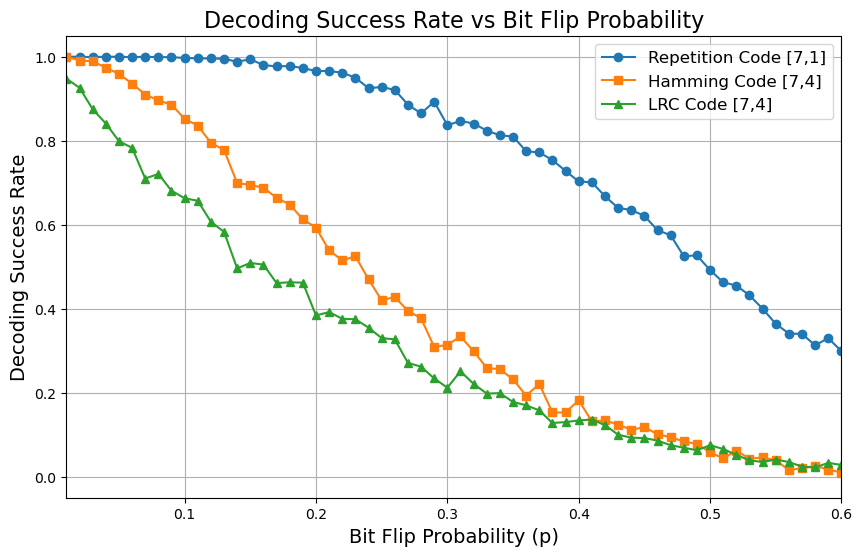

In [45]:
plot_success_rates(p_list, repetition_success_rates, hamming_success_rates, lrc_success_rates)


In [ ]:
# Repetition Code (short term memory) is very noisy, success rate is low (around 50%) no matter the noise level. It is weak but briefly sufficient. No strong structure is needed to decay slowly
# Hamming Code (episodic memory) relies on structure so it fails gradually as noise increases
# LRC (semantic memory) relies on partial recovery so it survives small disruption but collapses when overwhelmed
